In [1]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import pandas as pd
# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('data/meshlab.stl',remove_duplicate_polygons=1,calculate_normals=False,)
import numpy as np

In [2]:
import operator
normals=pd.DataFrame(your_mesh.normals)
values,counts=np.unique(normals[2], return_counts=True)
max(enumerate(counts), key=operator.itemgetter(1))
values[3733]

-0.004129074

In [3]:
your_mesh.points[0]

array([18.81639, 16.13502, 21.85584, 18.75863, 16.10805, 22.8669 ,
       18.78258, 16.11923, 21.85014], dtype=float32)

In [4]:
idx=0
U=your_mesh.v1[idx]-your_mesh.v0[idx]
V=your_mesh.v2[idx]-your_mesh.v0[idx]

np.cross(V,U)

array([-1.61173977e-02,  3.45128402e-02, -1.04657374e-07], dtype=float32)

In [5]:
pt1=np.array([1.881639e+01,1.613502e+01,2.185584e+01])
pt2=np.array([1.875863e+01,1.610805e+01,2.286690e+01])
pt3=np.array([1.878258e+01,1.611923e+01,2.185014e+01])

In [6]:
your_mesh.v0[0]

array([18.81639, 16.13502, 21.85584], dtype=float32)

In [7]:
U=pt2-pt1
V=pt3-pt1
np.cross(V,U)

array([-1.61183664e-02,  3.45131706e-02, -1.74700000e-07])

In [8]:
toplayer_points=pd.DataFrame(your_mesh.points[normals[normals[2]>=0].index])
toplayer_points[toplayer_points.eq(40.784870).any(axis=1) & toplayer_points.eq(41.287041).any(axis=1) & toplayer_points.eq(41.347549).any(axis=1) ]

,0,1,2,3,4,5,6,7,8
93,40.78487,70.34066,32.291561,41.287041,71.570557,32.4622,41.347549,72.2509,32.542709


In [9]:
toplayer_v0=pd.DataFrame(your_mesh.v0[normals[normals[2]>0].index])
toplayer_v1=pd.DataFrame(your_mesh.v1[normals[normals[2]>0].index])
toplayer_v2=pd.DataFrame(your_mesh.v2[normals[normals[2]>0].index])
toplayer=pd.concat([toplayer_v0,toplayer_v1,toplayer_v2])

In [10]:
toplayer=toplayer.drop_duplicates()
toplayer=toplayer.dropna()
toplayer.shape

(2587, 3)

In [11]:
toplayer.dtypes

0    float32
1    float32
2    float32
dtype: object

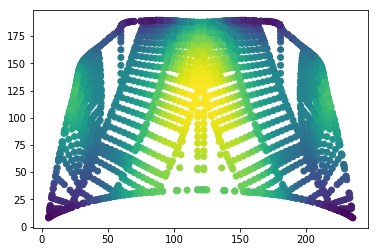

In [12]:
import matplotlib.pyplot as plt
plt.scatter(toplayer[0], toplayer[1], c=toplayer[2])
plt.show()

In [13]:
idx=300
selected_points=toplayer[:idx]

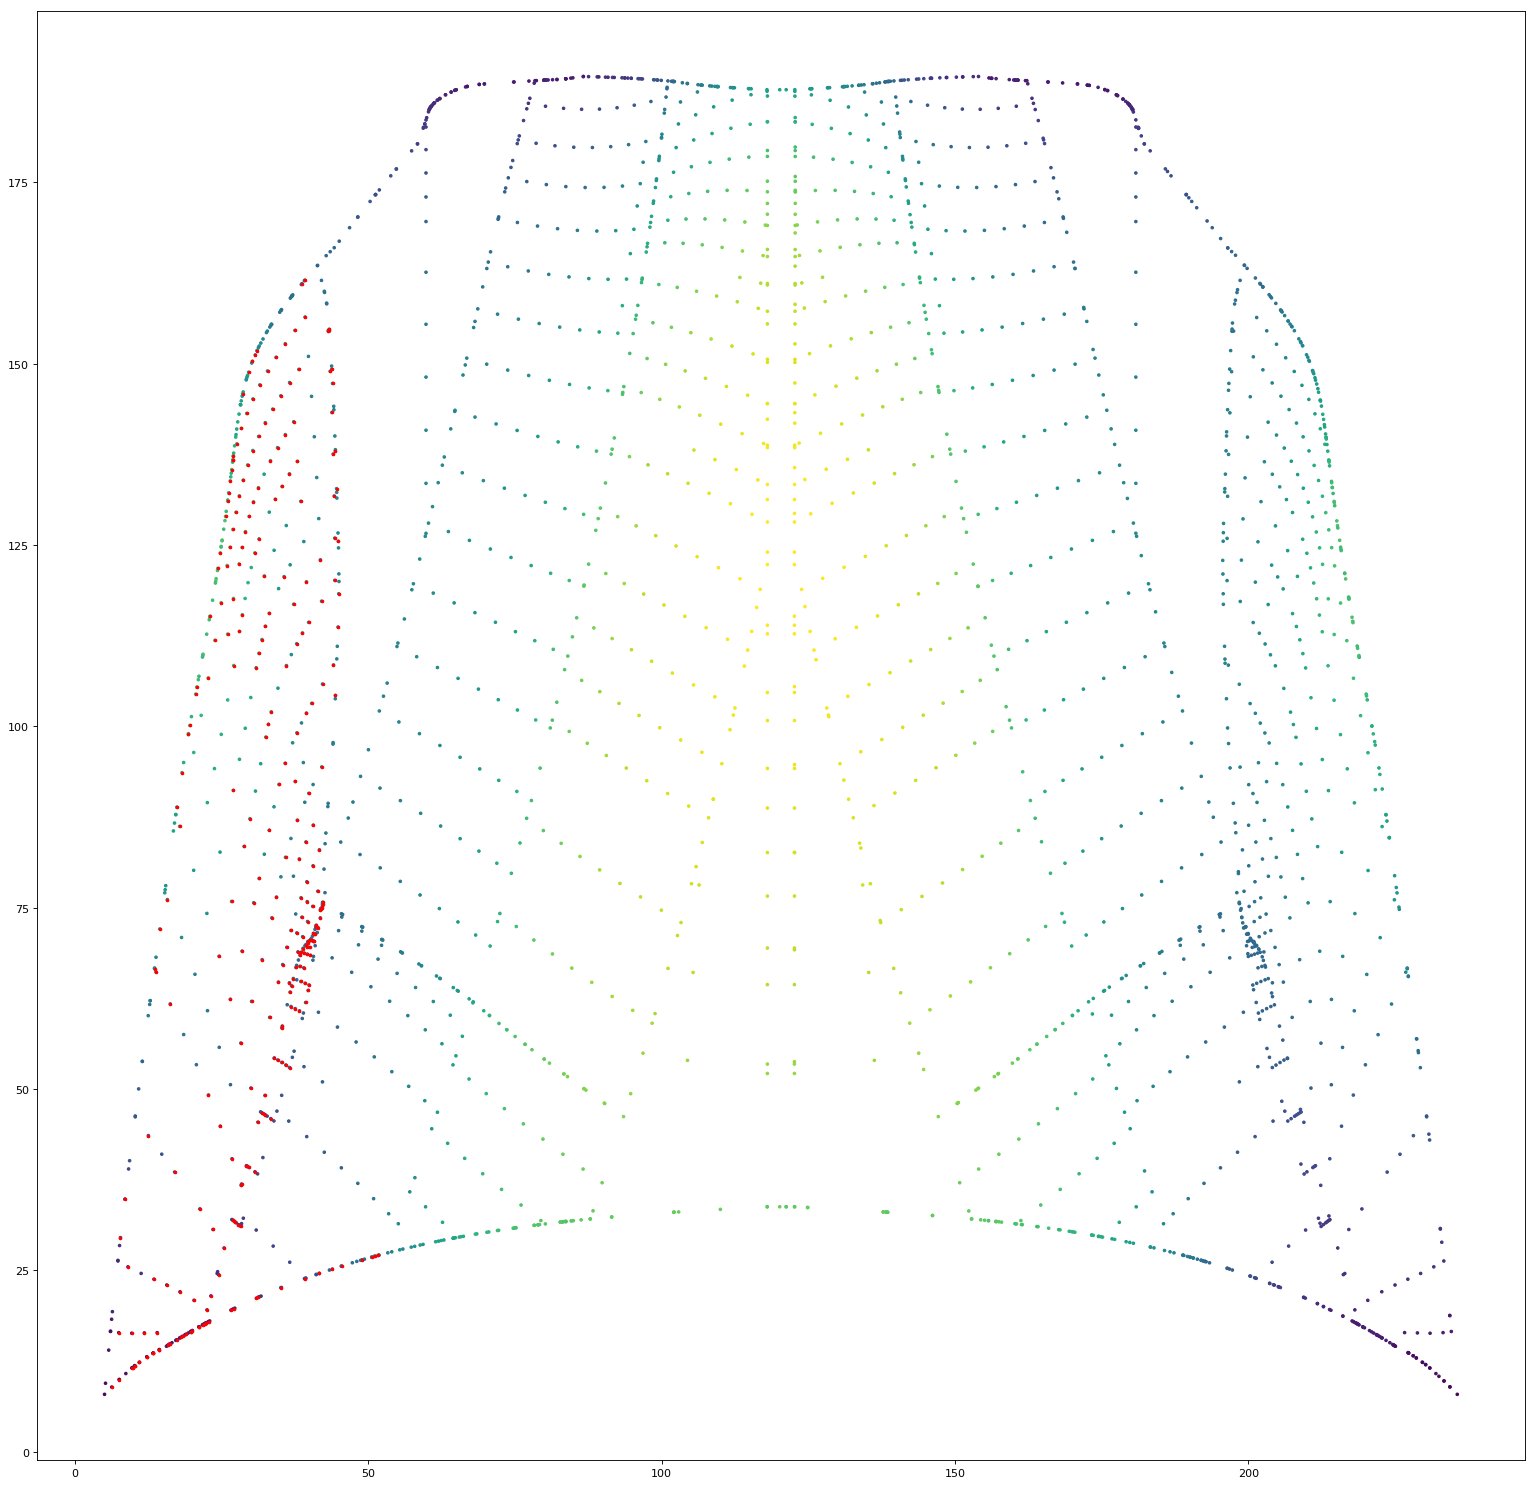

In [14]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 24), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(toplayer[0], toplayer[1], c=toplayer[2],s=5)
plt.scatter(selected_points[0], selected_points[1], c="red",s=5)

plt.show()

In [64]:
from operator import itemgetter
from collections import defaultdict

from copy import copy

def point_to_hashmap(vector):
    data_dict = defaultdict(list)
    a,b=zip(*sorted(enumerate(vector[:,0]), key=itemgetter(1)))
    for idx,coordinate in zip(a,b):
        data_dict[coordinate].append(idx)
    return data_dict



def get_adj_polygons(selected_polygons):
    v0_hashmap=point_to_hashmap(selected_polygons[:,0:3])
    v1_hashmap=point_to_hashmap(selected_polygons[:,3:6])
    v2_hashmap=point_to_hashmap(selected_polygons[:,6:9])
    #adj_polygons=defaultdict(lambda: defaultdict(list))
    adj_polygons=defaultdict(list)

    for v in v0_hashmap:
        for c0 in v0_hashmap[v]:

            for c00 in v0_hashmap[v]:
                v0_a=selected_polygons[c0,0:3]
                v1_a=selected_polygons[c0,3:6]
                v2_a=selected_polygons[c0,6:9]
                v0_b=selected_polygons[c00,0:3]
                v1_b=selected_polygons[c00,3:6]
                v2_b=selected_polygons[c00,6:9]
                if list(v0_a)==list(v0_b) and c0!=c00:
                    if( (list(v1_a)==list(v1_b) or list(v1_a)==list(v2_b)) or 
                            (list(v2_a)==list(v1_b) or list(v2_a)==list(v2_b))):
                        if c0 not in adj_polygons[c00] or c00 not in adj_polygons[c0]:
                            adj_polygons[c0].append(c00)
                            adj_polygons[c00].append(c0)        
            for c1 in v1_hashmap[v]:
                v0_a=selected_polygons[c0,0:3]
                v1_a=selected_polygons[c0,3:6]
                v2_a=selected_polygons[c0,6:9]
                v0_b=selected_polygons[c1,0:3]
                v1_b=selected_polygons[c1,3:6]
                v2_b=selected_polygons[c1,6:9]
                if list(v0_a)==list(v1_b): 
                    if((list(v1_a)==list(v0_b) or list(v1_a)==list(v2_b))) or  (list(v2_a)==list(v0_b) or list(v2_a)==list(v2_b)):
                        if c0 not in adj_polygons[c1] or c1 not in adj_polygons[c0]:
                            adj_polygons[c0].append(c1)
                            adj_polygons[c1].append(c0)                  
            for c2 in v2_hashmap[v]:
                v0_a=selected_polygons[c0,0:3]
                v1_a=selected_polygons[c0,3:6]
                v2_a=selected_polygons[c0,6:9]
                v0_b=selected_polygons[c2,0:3]
                v1_b=selected_polygons[c2,3:6]
                v2_b=selected_polygons[c2,6:9]
                if list(v0_a)==list(v2_b): # and c0!=c2:  
                    if(list(v1_a)==list(v0_b) or list(v1_a)==list(v1_b)) or (list(v2_a)==list(v0_b) or list(v2_a)==list(v1_b)):
                        if c0 not in adj_polygons[c2] or c2 not in adj_polygons[c0]:
                            adj_polygons[c0].append(c2)
                            adj_polygons[c2].append(c0)

        
    return adj_polygons


def get_connected_region(selected_polygons):

    adj_polygons=get_adj_polygons(selected_polygons)
    polygons=copy(adj_polygons)
    connected_regions=defaultdict(list)
    key_idx=0
    max_idx=len(selected_polygons)
    visited=[False]*max_idx
    while(key_idx<max_idx):
        stack_v1=[]
        stack_v1+=adj_polygons[key_idx]
        adj_polygons[key_idx]=[]
        # Tree traversal v1
        while len(stack_v1)>0:
            node=stack_v1.pop(0)
            if key_idx==node or len(adj_polygons[node])==0:
                continue
            
            for adj_node in adj_polygons[node]:
                if(not visited[adj_node]):
                    connected_regions[key_idx]+=[adj_node]
                    stack_v1+=[adj_node]
                    visited[adj_node]=True


            adj_polygons[node]=[]
        key_idx+=1
    return connected_regions


## Find disjoint areas

2 polygons must share an edge to be joined. To share an edge they must share two vertices

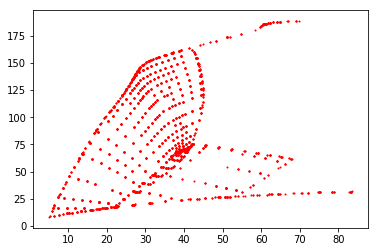

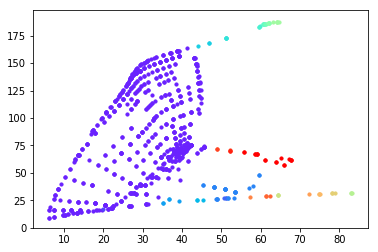

In [58]:
toplayer_polygons=pd.DataFrame(your_mesh.points[normals[normals[2]>0].index])
selected_polygons=np.array(toplayer_polygons)[:1000]
_df=pd.DataFrame(selected_polygons, index=None)
plt.scatter(_df[0], _df[1], c="red", s=1)
plt.scatter(_df[3], _df[4], c="red", s=1)
plt.scatter(_df[6], _df[7], c="red", s=1)

import matplotlib.cm as cm

a=get_connected_region(selected_polygons)
plt.show()
colors = iter(cm.rainbow(np.linspace(0, 1, len(a.keys()))))
for idx in a:
    idxs=a[idx]
    color2=next(colors)
    if(idx==0):
        continue
    plt.scatter(selected_polygons[idxs][:,0], selected_polygons[idxs][:,1], c=[color2], s=10)

plt.show()

In [59]:
"""
def point_to_hashmap(vector):
    data_dict = defaultdict(list)
    a,b=zip(*sorted(enumerate(vector[:,0]), key=itemgetter(1)))
    for idx,coordinate in zip(a,b):
        data_dict[coordinate].append(idx)
    return data_dict
"""
print(a.keys())
#v0_hashmap=point_to_hashmap(connected_region[:,0:3])
#v1_hashmap=point_to_hashmap(connected_region[:,3:6])
#v2_hashmap=point_to_hashmap(connected_region[:,6:9])

dict_keys([0, 2, 11, 27, 30, 39, 41, 852, 853, 860, 865, 869, 872, 876, 884, 887, 888, 891, 894, 899, 901, 912, 915, 918])


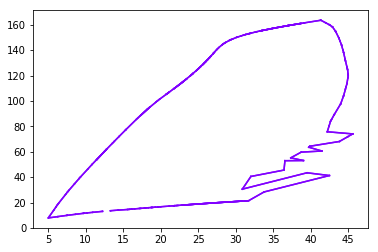

In [63]:
colors = iter(cm.rainbow(np.linspace(0, .8, len(a.keys()))))

for region in [2]:#a:
    connected_region=selected_polygons[a[region]]
    #print(len(connected_region))
    x1=(connected_region[:,0]).flatten()
    y1=(connected_region[:,1]).flatten()
    x2=(connected_region[:,3]).flatten()
    y2=(connected_region[:,4]).flatten()
    x3=(connected_region[:,6]).flatten()
    y3=(connected_region[:,7]).flatten()
    line_segments=[]
    
    _color=next(colors)
    for _idx1,_x1 in enumerate(x1):
        line_segments.append([[x1[_idx1],x2[_idx1]],[y1[_idx1],y2[_idx1]]])
        line_segments.append([[x2[_idx1],x1[_idx1]],[y2[_idx1],y1[_idx1]]])
        line_segments.append([[x2[_idx1],x3[_idx1]],[y2[_idx1],y3[_idx1]]])
        line_segments.append([[x3[_idx1],x2[_idx1]],[y3[_idx1],y2[_idx1]]])
        line_segments.append([[x3[_idx1],x1[_idx1]],[y3[_idx1],y1[_idx1]]])
        line_segments.append([[x1[_idx1],x3[_idx1]],[y1[_idx1],y3[_idx1]]])

        #plt.plot([x1[_idx1],x2[_idx1]],[y1[_idx1],y2[_idx1]],'r-')
        #plt.plot([x2[_idx1],x3[_idx1]],[y2[_idx1],y3[_idx1]],'r-')
        #plt.plot([x3[_idx1],x2[_idx1]],[y3[_idx1],y2[_idx1]],'r-')
        #plt.plot([x3[_idx1],x1[_idx1]],[y3[_idx1],y1[_idx1]],'r-')
    _v,_c=np.unique(np.array(line_segments),return_counts=True,axis=0)
    #plt.show()
    unique_lines=_v[np.where(_c < 2)[0]]
    #print(len(unique_lines))
    for _l in unique_lines:
        plt.plot(list(_l[0]),list(_l[1]),'r-',c=_color)

    
#idxs=sorted(uniques)
#x=(connected_region[idxs][:,0]).flatten()
#y=(connected_region[idxs][:,1]).flatten()
#plt.plot(x,y, 'b.', lw=2)

In [54]:
len(np.where(_c < 2)[0])

26

In [ ]:
import matplotlib.cm as cm
import itertools
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

for idx in a:
    idxs=a[idx]
    if(len(idxs)<5):
        continue
    print(idx)
    region=selected_polygons[idxs][:,0:2]
    x=(selected_polygons[idxs][:,0]).flatten()
    y=(selected_polygons[idxs][:,1]).flatten()
    v0=np.array(list(zip(x,y)))
    x=(selected_polygons[idxs][:,3]).flatten()
    y=(selected_polygons[idxs][:,4]).flatten()
    v1=np.array(list(zip(x,y)))
    x=(selected_polygons[idxs][:,6]).flatten()
    y=(selected_polygons[idxs][:,7]).flatten()
    v2=np.array(list(zip(x,y)))
    edge1=np.concatenate((np.array(list(zip(v0,v1))),np.array(list(zip(v1,v0)))))
    print(edge1)
    edge2=np.concatenate((np.array(list(zip(v1,v2))),np.array(list(zip(v2,v1)))))
    edge3=np.concatenate((np.array(list(zip(v0,v2))),np.array(list(zip(v2,v0)))))
    edges=np.concatenate((edge1,edge2,edge3))
    uniques=np.unique(edges, return_counts=True,axis=0)
    border=uniques[0][np.where(uniques[1]==1)]
    print(border)
    #last_edge=np.concatenate(([border[0,0,:]],[border[-1,0,:]]))
    #border=np.concatenate((border,[last_edge]))
    ordered_edges=[]
    for edge in border:
        ordered_edges.append(list(edge[0,:]))
        for edge2 in border:
            if list(edge[0,:]) == list(edge2[1,:]) and  list(edge[1,:]) == list(edge2[0,:]):                
                #print(edge)
                #print(edge2)
                #print("-----")
                ordered_edges.append(list(edge2[1,:]))
        
        x=edge[:,0]
        y=edge[:,1]
        plt.plot(x,y, 'r-', lw=2)
    #print(ordered_edges)
plt.show()
colors = iter(cm.rainbow(np.linspace(0, 1, len(a.keys()))))
for idx in a:
    idxs=a[idx]
    color2=next(colors)
    if(len(idxs)<5):
        continue
    plt.scatter(selected_polygons[idxs][:,0], selected_polygons[idxs][:,1], c=[color2], s=10)
    
np.meshgrid(np.linspace(-5, 5, 5),np.linspace(-12, -3, 3))
plt.show()

In [ ]:
np.mgrid[0:5,0:5,0:5]